# Imports 

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from torchinfo import summary
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import warnings
from matplotlib.patches import Rectangle
import tkinter as tk
from tkinter import filedialog, messagebox
import numpy as np
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import random

Data splitting (Train / Validation / Test)

In [2]:
# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# NOTE: The data path has been set to your specified Windows location.
DATA_DIR = r"C:\Users\pc\Downloads\archive (1)\plantvillage dataset\color" 

# Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
NUM_EPOCHS = 20 # Start with a small number, increase for full training
SPLIT_RATIOS = {'train': 0.7, 'val': 0.2, 'test': 0.1}

Using device: cuda


Data Transforms

In [3]:
# Define data transforms with required augmentations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(), # Orientation Augmentation
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Color Augmentation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the full dataset
try:
    full_dataset = datasets.ImageFolder(DATA_DIR)
except Exception as e:
    print(f"Error loading dataset from {DATA_DIR}. Please check the path and file structure.")
    print(f"Error details: {e}")
    # Exit or use dummy data if loading fails
    raise

class_names = full_dataset.classes
num_classes = len(class_names)

print(f"Total classes found: {num_classes}")
print(f"Class names: {class_names}")
print(f"Total images in dataset: {len(full_dataset)}")

# Get indices for the full dataset
all_indices = list(range(len(full_dataset)))

# Calculate split sizes
train_size = int(SPLIT_RATIOS['train'] * len(full_dataset))
val_size = int(SPLIT_RATIOS['val'] * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size # Remaining for test

# 1. Split Train/Temp (70% / 30%)
train_indices, temp_indices = train_test_split(
    all_indices, 
    train_size=train_size, 
    test_size=val_size + test_size, 
    stratify=full_dataset.targets, 
    random_state=42
)

# 2. Split Val/Test from the remaining (20% / 10%)
val_ratio = val_size / (val_size + test_size)

val_indices, test_indices = train_test_split(
    temp_indices, 
    train_size=val_ratio, 
    stratify=[full_dataset.targets[i] for i in temp_indices], 
    random_state=42
)

# Create Subsets with appropriate transforms
train_dataset = Subset(datasets.ImageFolder(DATA_DIR, transform=data_transforms['train']), train_indices)
val_dataset = Subset(datasets.ImageFolder(DATA_DIR, transform=data_transforms['val']), val_indices)
test_dataset = Subset(datasets.ImageFolder(DATA_DIR, transform=data_transforms['test']), test_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0) # num_workers=0 for Windows compatibility
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("\n--- Dataset Split Summary ---")
print(f"Train set size: {len(train_dataset)} ({SPLIT_RATIOS['train']*100}%)")
print(f"Validation set size: {len(val_dataset)} ({SPLIT_RATIOS['val']*100}%)")
print(f"Test set size: {len(test_dataset)} ({SPLIT_RATIOS['test']*100}%)")

Total classes found: 38
Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spot

Build Model

In [4]:
def get_resnet50_model(num_classes):
    # Load pre-trained ResNet50
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    
    # Freeze all the parameters in the network
    for param in model.parameters():
        param.requires_grad = False

    # Replace the final fully connected layer with a new one for our number of classes
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    # Unfreeze the final layer and the last few convolutional blocks for fine-tuning
    for param in model.fc.parameters():
        param.requires_grad = True
        
    # Unfreeze the parameters of the last convolutional block (layer4)
    for param in model.layer4.parameters():
        param.requires_grad = True
        
    return model

model = get_resnet50_model(num_classes).to(DEVICE)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
# Use a lower learning rate for fine-tuning
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) # Decay LR every 5 epochs

print("Model setup complete. Ready for training.")

Model setup complete. Ready for training.


Training the model on the data

In [5]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, 
                num_epochs=NUM_EPOCHS, patience=7, checkpoint_path='best_checkpoint.pth'):
    """
    Training function with Early Stopping and Full Checkpoint Saving
    
    Parameters:
    -----------
    patience : int
        عدد الـ epochs اللي الموديل يستنى فيها تحسن قبل ما يوقف (default: 7)
    checkpoint_path : str
        مسار حفظ الـ checkpoint الكامل (default: 'best_checkpoint.pth')
    """
    best_acc = 0.0
    best_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        if early_stop:
            print(f"\n⚠️ Early stopping triggered after {epoch} epochs")
            break
            
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        scheduler.step()
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())
        
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        
        # --- Early Stopping Logic & Checkpoint Saving ---
        if val_acc > best_acc:
            best_acc = val_acc
            best_loss = val_loss
            epochs_no_improve = 0
            
            # حفظ الـ checkpoint الكامل
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_acc': best_acc,
                'best_loss': best_loss,
                'history': history,
                'num_classes': len(train_loader.dataset.dataset.classes) if hasattr(train_loader.dataset, 'dataset') else num_classes,
                'class_names': train_loader.dataset.dataset.classes if hasattr(train_loader.dataset, 'dataset') else class_names
            }
            
            torch.save(checkpoint, checkpoint_path)
            # حفظ الـ weights فقط للاستخدام السريع
            torch.save(model.state_dict(), 'best_resnet50_model.pth')
            
            print(f"✓ Saved checkpoint (Val Acc: {best_acc:.4f})")
        else:
            epochs_no_improve += 1
            print(f"⚠️ No improvement for {epochs_no_improve} epoch(s) (Best: {best_acc:.4f})")
            
            if epochs_no_improve >= patience:
                print(f"\n🛑 Early stopping! No improvement for {patience} consecutive epochs")
                early_stop = True
    
    print(f'\n{"="*60}')
    print(f'Training Complete!')
    print(f'Best Val Acc: {best_acc:.4f}')
    print(f'Best Val Loss: {best_loss:.4f}')
    print(f'Total epochs trained: {len(history["train_loss"])}')
    print(f'Checkpoint saved at: {checkpoint_path}')
    print(f'{"="*60}')
    
    return model, history


# ============= استخدام الدالة =============
trained_model, training_history = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS,
    patience=7,
    checkpoint_path='best_checkpoint.pth'
)


Epoch 1/20
----------
Train Loss: 0.3629 Acc: 0.8902
Val Loss: 0.0965 Acc: 0.9659
✓ Saved checkpoint (Val Acc: 0.9659)

Epoch 2/20
----------
Train Loss: 0.1153 Acc: 0.9634
Val Loss: 0.0546 Acc: 0.9815
✓ Saved checkpoint (Val Acc: 0.9815)

Epoch 3/20
----------
Train Loss: 0.0908 Acc: 0.9699
Val Loss: 0.0465 Acc: 0.9857
✓ Saved checkpoint (Val Acc: 0.9857)

Epoch 4/20
----------
Train Loss: 0.0624 Acc: 0.9800
Val Loss: 0.0384 Acc: 0.9879
✓ Saved checkpoint (Val Acc: 0.9879)

Epoch 5/20
----------
Train Loss: 0.0566 Acc: 0.9812
Val Loss: 0.0622 Acc: 0.9793
⚠️ No improvement for 1 epoch(s) (Best: 0.9879)

Epoch 6/20
----------
Train Loss: 0.0227 Acc: 0.9931
Val Loss: 0.0186 Acc: 0.9945
✓ Saved checkpoint (Val Acc: 0.9945)

Epoch 7/20
----------
Train Loss: 0.0142 Acc: 0.9956
Val Loss: 0.0180 Acc: 0.9941
⚠️ No improvement for 1 epoch(s) (Best: 0.9945)

Epoch 8/20
----------
Train Loss: 0.0128 Acc: 0.9957
Val Loss: 0.0171 Acc: 0.9949
✓ Saved checkpoint (Val Acc: 0.9949)

Epoch 9/20
------

Accuracy Plot

In [ ]:
def plot_training_history(history):
    epochs = range(1, len(history['train_acc']) + 1)

    plt.figure(figsize=(8,5))
    plt.plot(epochs, history['train_acc'])
    plt.plot(epochs, history['val_acc'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
    plt.grid(True)
    plt.show()

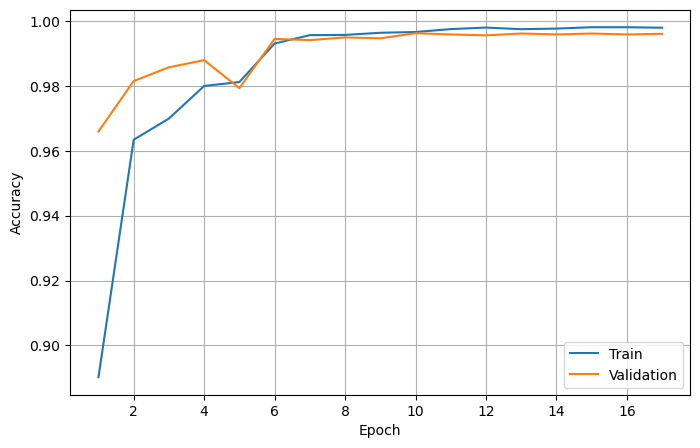

In [ ]:
plot_training_history(training_history)

Loss Plot

In [ ]:
def plot_loss_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(8,5))
    plt.plot(epochs, history['train_loss'])
    plt.plot(epochs, history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])
    plt.grid(True)
    plt.show()

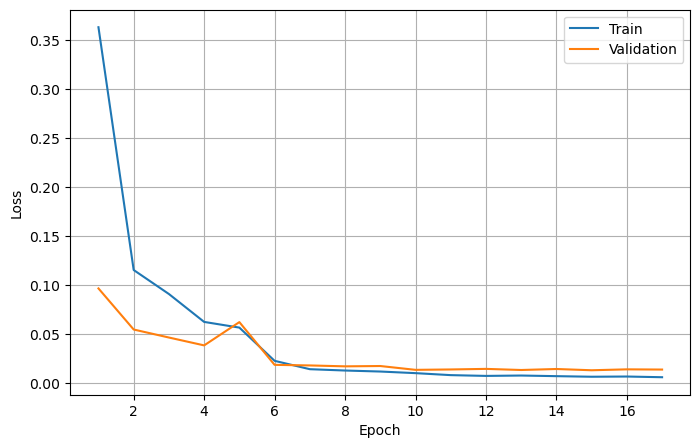

In [12]:
plot_loss_history(training_history)

Load Model

In [5]:
def load_checkpoint(checkpoint_path, model, optimizer=None, scheduler=None):
    """
    تحميل الـ checkpoint الكامل
    
    Returns:
    --------
    model, optimizer, scheduler, start_epoch, history, best_acc
    """
    print(f"Loading checkpoint from: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if optimizer is not None and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    if scheduler is not None and 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    start_epoch = checkpoint.get('epoch', 0)
    history = checkpoint.get('history', {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []})
    best_acc = checkpoint.get('best_acc', 0.0)
    
    print(f"✓ Checkpoint loaded successfully!")
    print(f"  - Last epoch: {start_epoch}")
    print(f"  - Best Val Acc: {best_acc:.4f}")
    print(f"  - Training history length: {len(history['train_loss'])} epochs")
    
    return model, optimizer, scheduler, start_epoch, history, best_acc


# ============= مثال: تحميل الموديل للتقييم فقط =============
def load_model_for_evaluation(checkpoint_path, num_classes):
    """
    تحميل الموديل للتقييم فقط (بدون optimizer/scheduler)
    """
    # إنشاء الموديل
    model = models.resnet50(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    # تحميل الـ checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(DEVICE)
    model.eval()
    
    print(f"✓ Model loaded for evaluation")
    print(f"  - Best Val Acc: {checkpoint['best_acc']:.4f}")
    print(f"  - Trained for: {checkpoint['epoch']} epochs")
    
    # استرجاع معلومات إضافية
    class_names = checkpoint.get('class_names', None)
    history = checkpoint.get('history', None)
    
    return model, class_names, history


# ============= مثال: إكمال التدريب من checkpoint =============
def resume_training():
    """
    إكمال التدريب من آخر checkpoint
    """
    # إنشاء الموديل والـ optimizer والـ scheduler
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(DEVICE)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    # تحميل الـ checkpoint
    model, optimizer, scheduler, start_epoch, history, best_acc = load_checkpoint(
        checkpoint_path='best_checkpoint.pth',
        model=model,
        optimizer=optimizer,
        scheduler=scheduler
    )
    
    # إكمال التدريب
    print(f"\nResuming training from epoch {start_epoch + 1}...")
    trained_model, final_history = train_model(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=NUM_EPOCHS,
        patience=7
    )
    
    return trained_model, final_history


# ============= استخدام سريع للتقييم =============
# لو عايز تحمل الموديل بسرعة للتقييم:
model_eval, class_names_saved, history_saved = load_model_for_evaluation(
    checkpoint_path='best_checkpoint.pth',
    num_classes=num_classes
)

# بعدها تقدر تستخدمه في التقييم:
#true_labels, predictions = evaluate_model(model_eval, test_loader, class_names_saved)

c:\Users\pc\miniconda3\envs\ai4beg\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pc\miniconda3\envs\ai4beg\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\pc\AppData\Local\Temp\ipykernel_6960\2261119527.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_onl

✓ Model loaded for evaluation
  - Best Val Acc: 0.9962
  - Trained for: 10 epochs


Evaluate on test dataset

Using: cuda


C:\Users\pc\AppData\Local\Temp\ipykernel_6960\3092263867.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_resnet50_model.pth", map


==== Test Accuracy: 99.28% ====


==== Classification Report ====

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      1.00      0.99        63
                                 Apple___Black_rot       1.00      1.00      1.00        62
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        27
                                   Apple___healthy       1.00      1.00      1.00       165
                               Blueberry___healthy       1.00      0.99      1.00       151
          Cherry_(including_sour)___Powdery_mildew       0.99      0.99      0.99       105
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00        85
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.98      0.82      0.89        51
                       Corn_(maize)___Common_rust_       1.00      0.98      0.99       119
           

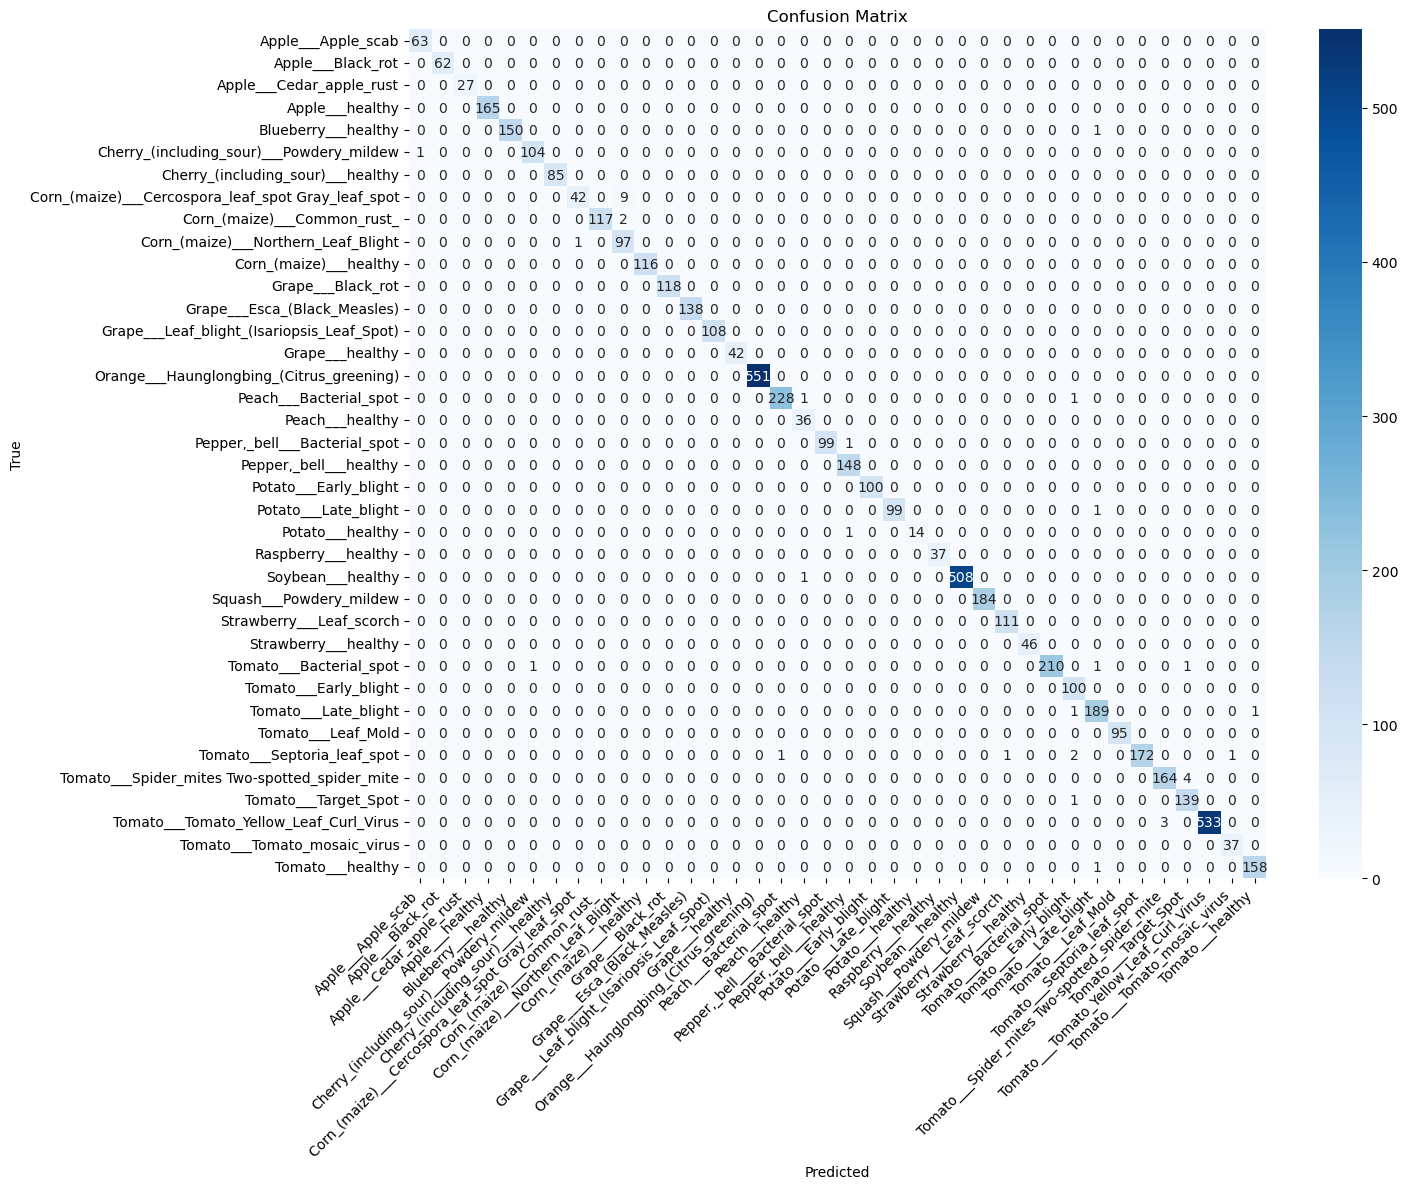

In [6]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", DEVICE)

# ========== تقييم الموديل ==========
def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- Test Accuracy ---
    test_acc = accuracy_score(all_labels, all_preds)
    print(f"\n==== Test Accuracy: {test_acc * 100:.2f}% ====\n")

    # --- Classification Report ---
    print("\n==== Classification Report ====\n")
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    # --- Confusion Matrix ---
    print("\n==== Confusion Matrix ====\n")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return all_labels, all_preds, test_acc

# ========== تحميل الموديل ==========
model = models.resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model.load_state_dict(torch.load("best_resnet50_model.pth", map_location=DEVICE))
model = model.to(DEVICE)

# ========== تشغيل Evaluation ==========
true_labels, predictions, test_acc = evaluate_model(model, test_loader, class_names)


Layers 

In [7]:
backbone = models.resnet50(pretrained=True)
for name, layer in backbone.named_children():
    print(name, layer)

c:\Users\pc\miniconda3\envs\ai4beg\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pc\miniconda3\envs\ai4beg\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


conv1 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
bn1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
relu ReLU(inplace=True)
maxpool MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
layer1 Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05

Model Summary

In [ ]:
summary(
    model,
    input_size=(1, 3, 224, 224),  # (batch_size, channels, H, W)
    device='cuda'  # أو 'cpu'
)


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 38]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         (128)
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           (4,096)
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]    

Visualize Grad Cam

In [7]:
def visualize_grad_cam(
    model,
    class_names,
    device="cuda",
    dataset=None,
    image_path=None,
    transform=None,
    num_images=5
):
    """
    Unified Grad-CAM visualization with colored boxes:
    - dataset OR
    - external image

    Args:
        model: trained CNN
        class_names: list of classes
        device: cuda / cpu
        dataset: PyTorch Dataset (optional)
        image_path: path to external image (optional)
        transform: torchvision transform (required if image_path is used)
        num_images: number of dataset images
    """

    assert (dataset is not None) ^ (image_path is not None), \
        "Provide either dataset OR image_path (not both)"

    model.eval()
    model.to(device)

    target_layer = model.layer4[-1]
    cam = GradCAM(model=model, target_layers=[target_layer])

    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    # ======================================================
    # =============== External Image =======================
    # ======================================================
    if image_path is not None:

        image = Image.open(image_path).convert("RGB")
        input_tensor = transform(image)

        rgb_img = (
            input_tensor
            .permute(1, 2, 0)
            .cpu()
            .numpy() * std + mean
        )
        rgb_img = np.clip(rgb_img, 0, 1)

        input_batch = input_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_batch)
            pred_idx = output.argmax(dim=1).item()

        grayscale_cam = cam(
            input_tensor=input_batch,
            targets=[ClassifierOutputTarget(pred_idx)]
        )[0]

        cam_image = show_cam_on_image(
            rgb_img,
            grayscale_cam,
            use_rgb=True
        )

        fig = plt.figure(figsize=(10, 4))
        fig.patch.set_facecolor('white')

        ax1 = plt.subplot(1, 2, 1)
        ax1.imshow(rgb_img)
        ax1.set_title("Original", fontsize=12, fontweight='bold', pad=10)
        ax1.axis("off")
        
        # Add yellow box
        rect1 = Rectangle((0, 0), rgb_img.shape[1], rgb_img.shape[0], 
                        linewidth=8, edgecolor='#FFD700', facecolor='none')
        ax1.add_patch(rect1)

        ax2 = plt.subplot(1, 2, 2)
        ax2.imshow(cam_image)
        ax2.set_title("Grad-CAM", fontsize=12, fontweight='bold', pad=10)
        ax2.axis("off")
        
        # Add blue box
        rect2 = Rectangle((0, 0), cam_image.shape[1], cam_image.shape[0], 
                        linewidth=8, edgecolor='#4169E1', facecolor='none')
        ax2.add_patch(rect2)
        
        # Add prediction text below
        pred_text = f'Pred: {class_names[pred_idx]}'
        ax2.text(0.5, -0.05, pred_text, transform=ax2.transAxes,
                fontsize=11, fontweight='normal',
                verticalalignment='top', horizontalalignment='center')

        plt.tight_layout(pad=2)
        plt.show()
        return

    # ======================================================
    # ================= Dataset ============================
    # ======================================================
    fig, axes = plt.subplots(num_images, 2, figsize=(12, 5 * num_images))
    fig.patch.set_facecolor('white')
    
    if num_images == 1:
        axes = [axes]

    for i in range(num_images):

        idx = random.randint(0, len(dataset) - 1)
        input_tensor, label_idx = dataset[idx]

        rgb_img = (
            input_tensor
            .permute(1, 2, 0)
            .cpu()
            .numpy() * std + mean
        )
        rgb_img = np.clip(rgb_img, 0, 1)

        input_batch = input_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_batch)
            pred_idx = output.argmax(dim=1).item()

        grayscale_cam = cam(
            input_tensor=input_batch,
            targets=[ClassifierOutputTarget(pred_idx)]
        )[0]

        cam_image = show_cam_on_image(
            rgb_img,
            grayscale_cam,
            use_rgb=True
        )

        axes[i][0].imshow(rgb_img)
        axes[i][0].set_title("Original", fontsize=12, fontweight='bold', pad=10)
        axes[i][0].axis("off")
        
        # Add yellow box around original
        rect1 = Rectangle((0, 0), rgb_img.shape[1], rgb_img.shape[0], 
                        linewidth=8, edgecolor='#FFD700', facecolor='none')
        axes[i][0].add_patch(rect1)
        
        # True label text below
        true_text = f"True: {class_names[label_idx]}"
        axes[i][0].text(0.5, -0.05, true_text, transform=axes[i][0].transAxes,
                       fontsize=11, fontweight='normal',
                       verticalalignment='top', horizontalalignment='center')

        axes[i][1].imshow(cam_image)
        axes[i][1].set_title("Grad-CAM", fontsize=12, fontweight='bold', pad=10)
        axes[i][1].axis("off")
        
        # Add blue box around Grad-CAM
        rect2 = Rectangle((0, 0), cam_image.shape[1], cam_image.shape[0], 
                        linewidth=8, edgecolor='#4169E1', facecolor='none')
        axes[i][1].add_patch(rect2)
        
        # Prediction text below
        pred_text = f"Pred: {class_names[pred_idx]}"
        axes[i][1].text(0.5, -0.05, pred_text, transform=axes[i][1].transAxes,
                       fontsize=11, fontweight='normal',
                       verticalalignment='top', horizontalalignment='center')

    plt.tight_layout(pad=2)
    plt.show()

From DataSet

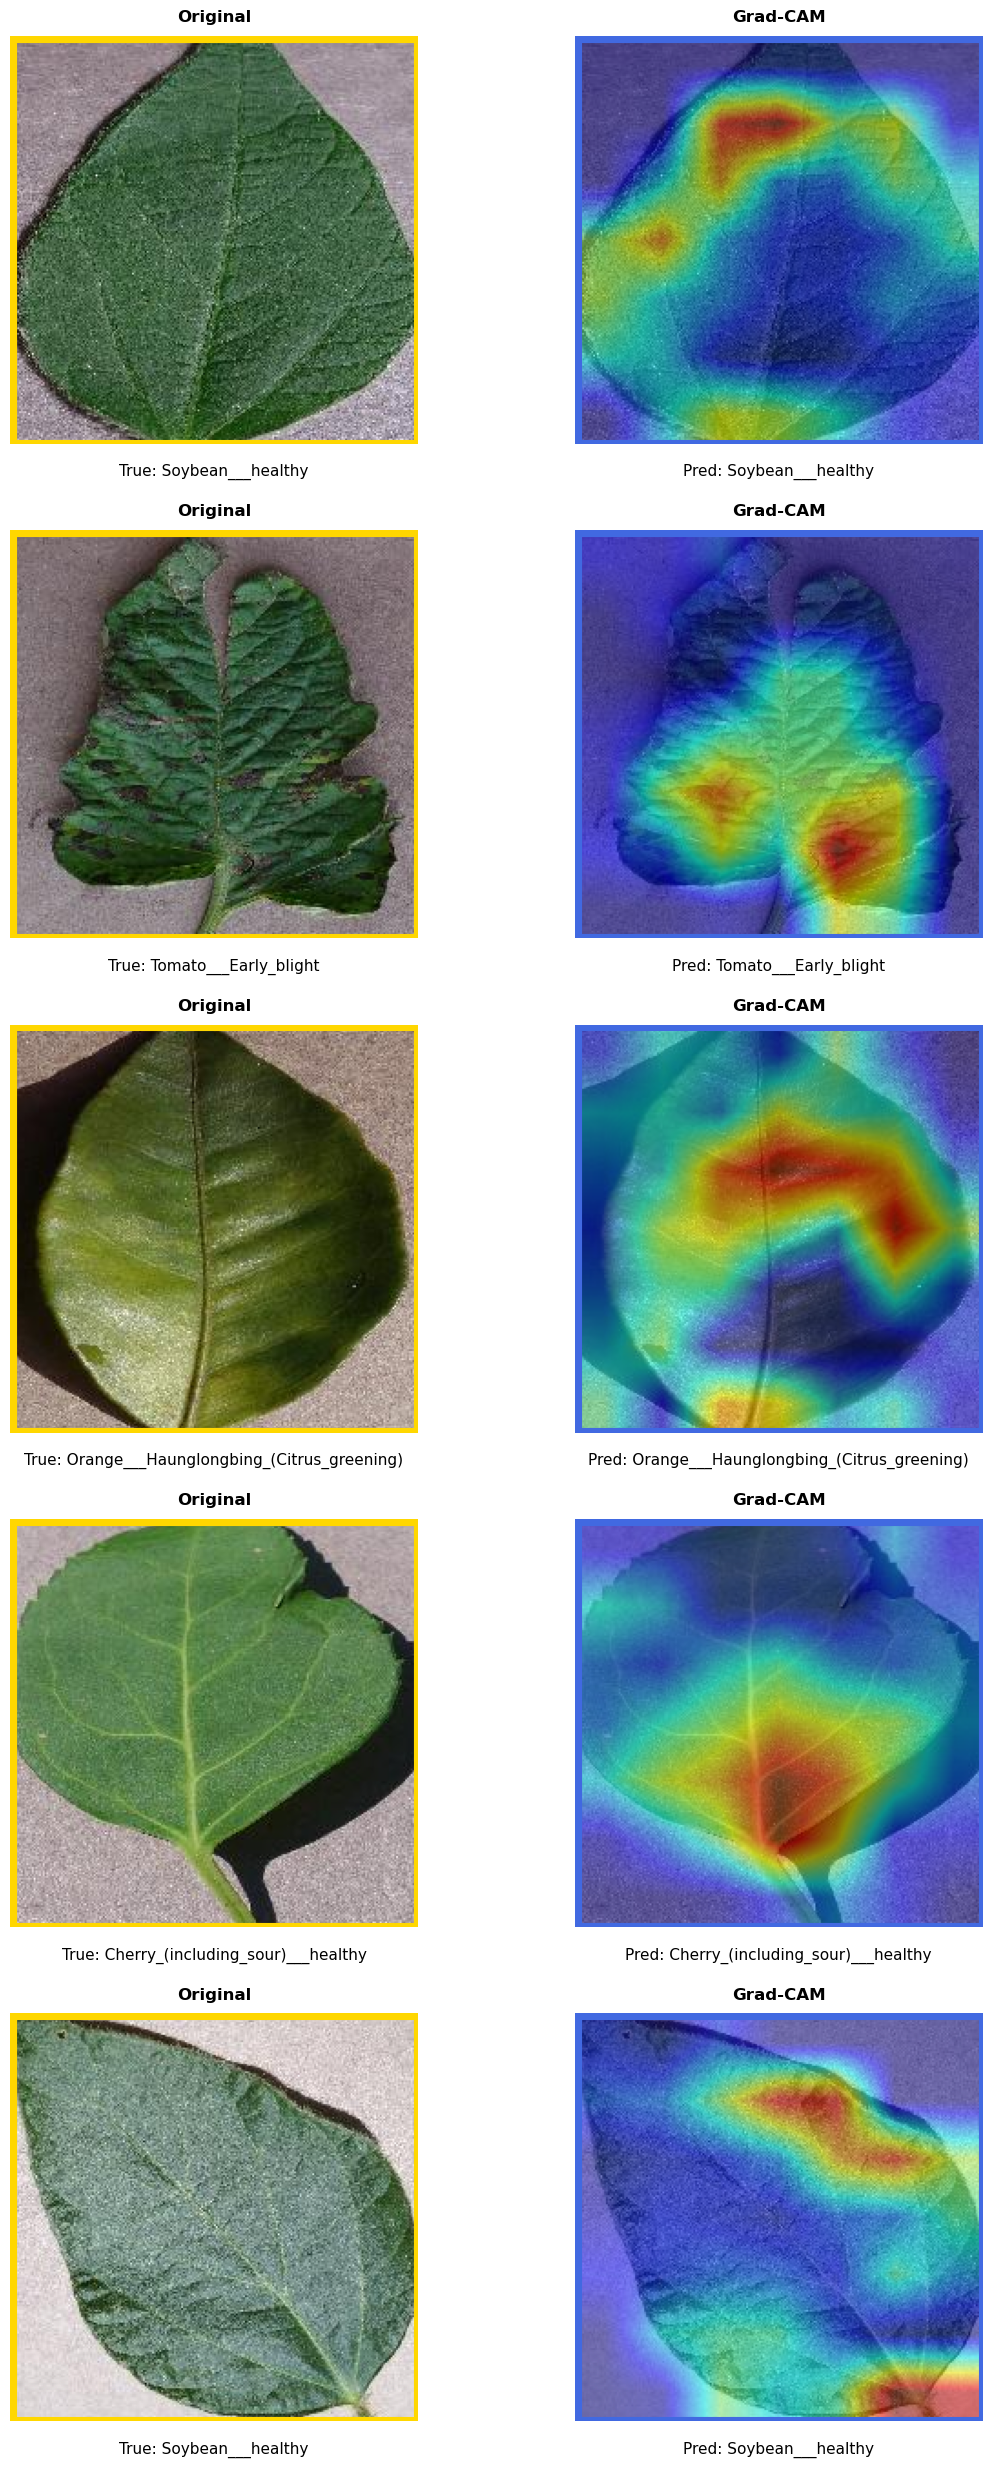

In [25]:
visualize_grad_cam(
    model=model,
    dataset=test_dataset,
    class_names=class_names,
    num_images=5,
    device=DEVICE
)


OutSource

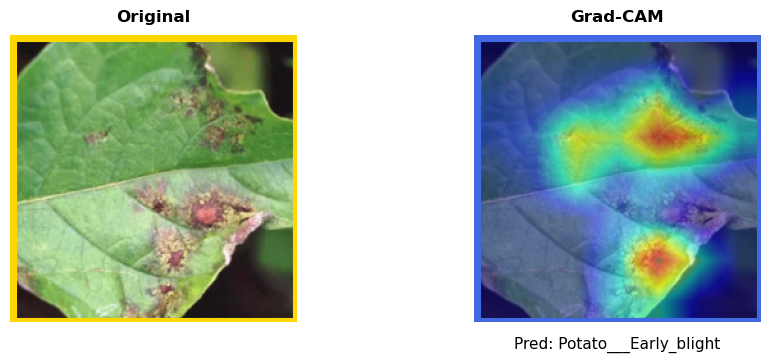

In [10]:
test_transform = data_transforms['test']

visualize_grad_cam(
    model=model,
    image_path=r"C:\Users\pc\Downloads\Potato-leaf-blight.webp",
    class_names=class_names,
    transform=test_transform,
    device=DEVICE
)


Grad_CAM GUI

In [8]:
class GradCAMGUI:
    def __init__(self, root, model, class_names, device="cuda", dataset=None, transform=None):
        self.root = root
        self.model = model
        self.class_names = class_names
        self.device = device
        self.dataset = dataset
        self.transform = transform
        
        self.model.eval()
        self.model.to(device)
        
        self.target_layer = model.layer4[-1]
        self.cam = GradCAM(model=model, target_layers=[self.target_layer])
        
        self.mean = np.array([0.485, 0.456, 0.406])
        self.std = np.array([0.229, 0.224, 0.225])
        
        self.setup_ui()
        
    def setup_ui(self):
        self.root.title("Grad-CAM Visualization Tool")
        self.root.geometry("1400x900")
        self.root.configure(bg='#f0f0f0')
        
        main_container = tk.Frame(self.root, bg='#f0f0f0')
        main_container.pack(fill=tk.BOTH, expand=True, padx=15, pady=15)
        
        title_frame = tk.Frame(main_container, bg='#2c3e50', height=60)
        title_frame.pack(fill=tk.X, pady=(0, 15))
        title_frame.pack_propagate(False)
        
        title_label = tk.Label(title_frame, text="🔍 Grad-CAM Visualization", 
                              font=('Arial', 18, 'bold'), bg='#2c3e50', fg='white')
        title_label.pack(pady=15)
        
        control_frame = tk.Frame(main_container, bg='white', relief=tk.RAISED, borderwidth=2)
        control_frame.pack(fill=tk.X, pady=(0, 15), ipady=10)
        
        mode_frame = tk.Frame(control_frame, bg='white')
        mode_frame.pack(side=tk.LEFT, padx=20, pady=10)
        
        tk.Label(mode_frame, text="Mode:", font=('Arial', 11, 'bold'), bg='white').pack(side=tk.LEFT, padx=5)
        self.mode_var = tk.StringVar(value="dataset")
        
        rb1 = tk.Radiobutton(mode_frame, text="📊 Dataset", variable=self.mode_var, 
                            value="dataset", command=self.on_mode_change, 
                            font=('Arial', 10), bg='white', selectcolor='#3498db')
        rb1.pack(side=tk.LEFT, padx=5)
        
        rb2 = tk.Radiobutton(mode_frame, text="🖼️ External Image", variable=self.mode_var, 
                            value="external", command=self.on_mode_change,
                            font=('Arial', 10), bg='white', selectcolor='#3498db')
        rb2.pack(side=tk.LEFT, padx=5)
        
        sep = tk.Frame(control_frame, width=2, bg='#ddd')
        sep.pack(side=tk.LEFT, fill=tk.Y, padx=10)
        
        self.dataset_frame = tk.Frame(control_frame, bg='white')
        self.dataset_frame.pack(side=tk.LEFT, padx=20, pady=10)
        
        tk.Label(self.dataset_frame, text="Number of Images:", 
                font=('Arial', 10), bg='white').pack(side=tk.LEFT, padx=5)
        self.num_images_var = tk.StringVar(value="3")
        num_spinner = tk.Spinbox(self.dataset_frame, from_=1, to=10, width=5, 
                                textvariable=self.num_images_var, font=('Arial', 10))
        num_spinner.pack(side=tk.LEFT, padx=5)
        
        visualize_btn = tk.Button(self.dataset_frame, text="▶ Visualize", 
                                 command=self.visualize_dataset,
                                 bg='#27ae60', fg='white', font=('Arial', 10, 'bold'),
                                 relief=tk.RAISED, borderwidth=2, padx=15, pady=5,
                                 cursor='hand2')
        visualize_btn.pack(side=tk.LEFT, padx=10)
        
        self.external_frame = tk.Frame(control_frame, bg='white')
        
        select_btn = tk.Button(self.external_frame, text="📁 Select Image", 
                              command=self.select_image,
                              bg='#3498db', fg='white', font=('Arial', 10, 'bold'),
                              relief=tk.RAISED, borderwidth=2, padx=15, pady=5,
                              cursor='hand2')
        select_btn.pack(side=tk.LEFT, padx=5)
        
        self.image_label = tk.Label(self.external_frame, text="No image selected",
                                   font=('Arial', 9, 'italic'), bg='white', fg='#7f8c8d')
        self.image_label.pack(side=tk.LEFT, padx=10)
        
        viz_btn = tk.Button(self.external_frame, text="▶ Visualize", 
                           command=self.visualize_external,
                           bg='#27ae60', fg='white', font=('Arial', 10, 'bold'),
                           relief=tk.RAISED, borderwidth=2, padx=15, pady=5,
                           cursor='hand2')
        viz_btn.pack(side=tk.LEFT, padx=5)
        
        canvas_container = tk.Frame(main_container, bg='white', relief=tk.SUNKEN, borderwidth=2)
        canvas_container.pack(fill=tk.BOTH, expand=True)
        
        self.canvas_frame = tk.Frame(canvas_container, bg='white')
        self.canvas_frame.pack(fill=tk.BOTH, expand=True, padx=5, pady=5)
        
        self.canvas = None
        self.selected_image_path = None
        
        self.on_mode_change()
        
    def on_mode_change(self):
        mode = self.mode_var.get()
        if mode == "dataset":
            self.dataset_frame.pack(side=tk.LEFT, padx=20)
            self.external_frame.pack_forget()
        else:
            self.external_frame.pack(side=tk.LEFT, padx=20)
            self.dataset_frame.pack_forget()
    
    def select_image(self):
        file_path = filedialog.askopenfilename(
            title="Select an image",
            filetypes=[("Image files", "*.jpg *.jpeg *.png *.bmp *.webp"), ("All files", "*.*")]
        )
        if file_path:
            self.selected_image_path = file_path
            filename = file_path.split('/')[-1] if '/' in file_path else file_path.split('\\')[-1]
            self.image_label.config(text=filename)
    
    def clear_canvas(self):
        if self.canvas:
            self.canvas.get_tk_widget().destroy()
    
    def visualize_external(self):
        if self.selected_image_path is None:
            messagebox.showerror("Error", "Please select an image first!")
            return
        
        try:
            self.clear_canvas()
            
            image = Image.open(self.selected_image_path).convert("RGB")
            input_tensor = self.transform(image)
            
            rgb_img = (input_tensor.permute(1, 2, 0).cpu().numpy() * self.std + self.mean)
            rgb_img = np.clip(rgb_img, 0, 1)
            
            input_batch = input_tensor.unsqueeze(0).to(self.device)
            
            with torch.no_grad():
                output = self.model(input_batch)
                pred_idx = output.argmax(dim=1).item()
            
            grayscale_cam = self.cam(
                input_tensor=input_batch,
                targets=[ClassifierOutputTarget(pred_idx)]
            )[0]
            
            cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
            
            # Create figure with GridSpec for better control
            fig = plt.figure(figsize=(13, 7))
            fig.patch.set_facecolor('white')
            
            # Add column titles at the top
            fig.text(0.27, 0.93, "Original", fontsize=16, fontweight='bold', 
                    ha='center', va='top')
            fig.text(0.73, 0.93, "Grad-CAM", fontsize=16, fontweight='bold', 
                    ha='center', va='top')
            
            # Create subplots with space for text below
            ax1 = plt.subplot(1, 2, 1)
            ax1.imshow(rgb_img)
            ax1.axis("off")
            
            rect1 = Rectangle((0, 0), rgb_img.shape[1], rgb_img.shape[0], 
                            linewidth=8, edgecolor='#FFD700', facecolor='none')
            ax1.add_patch(rect1)
            
            ax2 = plt.subplot(1, 2, 2)
            ax2.imshow(cam_image)
            ax2.axis("off")
            
            rect2 = Rectangle((0, 0), cam_image.shape[1], cam_image.shape[0], 
                            linewidth=8, edgecolor='#4169E1', facecolor='none')
            ax2.add_patch(rect2)
            
            # Add prediction text at the bottom in fixed position
            pred_text = f'Prediction: {self.class_names[pred_idx]}'
            fig.text(0.73, 0.08, pred_text, fontsize=12, fontweight='normal',
                    ha='center', va='center', 
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='#E8F5E9', 
                             edgecolor='#4CAF50', linewidth=2))
            
            plt.subplots_adjust(left=0.05, right=0.95, top=0.90, bottom=0.12, wspace=0.1)
            
            self.canvas = FigureCanvasTkAgg(fig, master=self.canvas_frame)
            self.canvas.draw()
            self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
            
        except Exception as e:
            messagebox.showerror("Error", f"Failed to process image: {str(e)}")
    
    def visualize_dataset(self):
        if self.dataset is None:
            messagebox.showerror("Error", "No dataset provided!")
            return
        
        try:
            num_images = int(self.num_images_var.get())
            self.clear_canvas()
            
            # Calculate figure height based on number of images
            fig_height = max(8, num_images * 3.5)
            fig = plt.figure(figsize=(14, fig_height))
            fig.patch.set_facecolor('white')
            
            # Add column titles at the top
            fig.text(0.27, 0.97, "Original", fontsize=16, fontweight='bold', 
                    ha='center', va='top')
            fig.text(0.73, 0.97, "Grad-CAM", fontsize=16, fontweight='bold', 
                    ha='center', va='top')
            
            # Calculate spacing
            space_per_image = 0.92 / num_images
            
            for i in range(num_images):
                idx = random.randint(0, len(self.dataset) - 1)
                input_tensor, label_idx = self.dataset[idx]
                
                rgb_img = (input_tensor.permute(1, 2, 0).cpu().numpy() * self.std + self.mean)
                rgb_img = np.clip(rgb_img, 0, 1)
                
                input_batch = input_tensor.unsqueeze(0).to(self.device)
                
                with torch.no_grad():
                    output = self.model(input_batch)
                    pred_idx = output.argmax(dim=1).item()
                
                grayscale_cam = self.cam(
                    input_tensor=input_batch,
                    targets=[ClassifierOutputTarget(pred_idx)]
                )[0]
                
                cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
                
                # Original image
                ax1 = plt.subplot(num_images, 2, i*2 + 1)
                ax1.imshow(rgb_img)
                ax1.axis("off")
                
                rect1 = Rectangle((0, 0), rgb_img.shape[1], rgb_img.shape[0], 
                                linewidth=8, edgecolor='#FFD700', facecolor='none')
                ax1.add_patch(rect1)
                
                # Grad-CAM image
                ax2 = plt.subplot(num_images, 2, i*2 + 2)
                ax2.imshow(cam_image)
                ax2.axis("off")
                
                rect2 = Rectangle((0, 0), cam_image.shape[1], cam_image.shape[0], 
                                linewidth=8, edgecolor='#4169E1', facecolor='none')
                ax2.add_patch(rect2)
                
                # Calculate vertical position for this row's text
                text_y_pos = 0.94 - (i + 0.85) * space_per_image
                
                # Add labels in fixed positions below each row
                true_text = f'True: {self.class_names[label_idx]}'
                pred_text = f'Pred: {self.class_names[pred_idx]}'
                
                fig.text(0.27, text_y_pos, true_text, fontsize=11, fontweight='normal',
                        ha='center', va='center',
                        bbox=dict(boxstyle='round,pad=0.4', facecolor='#FFF9C4', 
                                 edgecolor='#FBC02D', linewidth=1.5))
                
                fig.text(0.73, text_y_pos, pred_text, fontsize=11, fontweight='normal',
                        ha='center', va='center',
                        bbox=dict(boxstyle='round,pad=0.4', facecolor='#E8F5E9', 
                                 edgecolor='#4CAF50', linewidth=1.5))
            
            plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.02, 
                              hspace=0.15, wspace=0.1)
            
            self.canvas = FigureCanvasTkAgg(fig, master=self.canvas_frame)
            self.canvas.draw()
            self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
            
        except Exception as e:
            messagebox.showerror("Error", f"Failed to visualize: {str(e)}")

In [9]:
def launch_gradcam_gui(model, class_names, device="cuda", dataset=None, transform=None):
    """Launch the Grad-CAM GUI application."""
    root = tk.Tk()
    app = GradCAMGUI(root, model, class_names, device, dataset, transform)
    root.mainloop()

print("✅ Grad-CAM GUI loaded!")

✅ Grad-CAM GUI loaded!


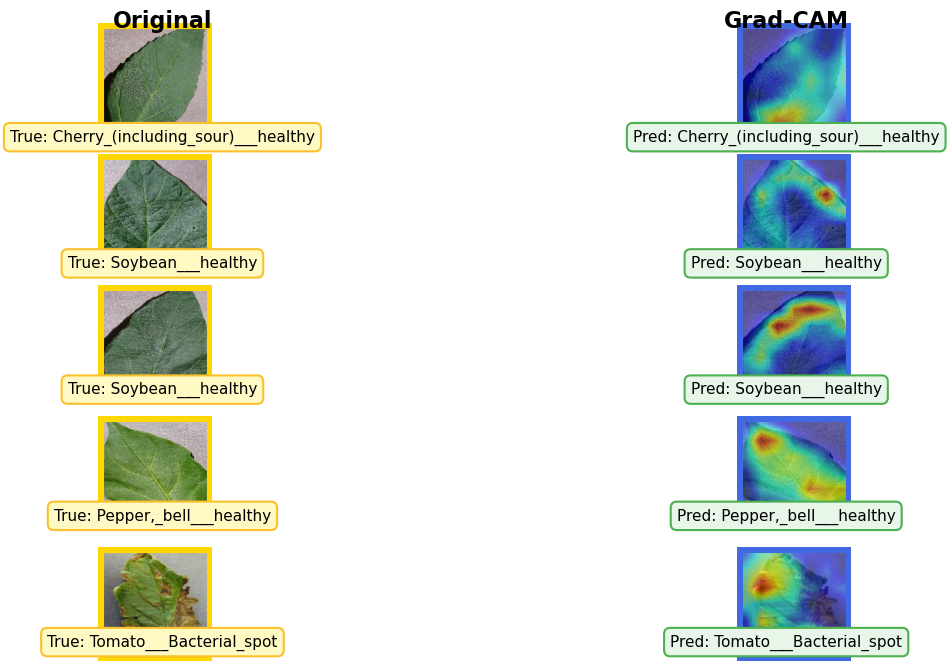

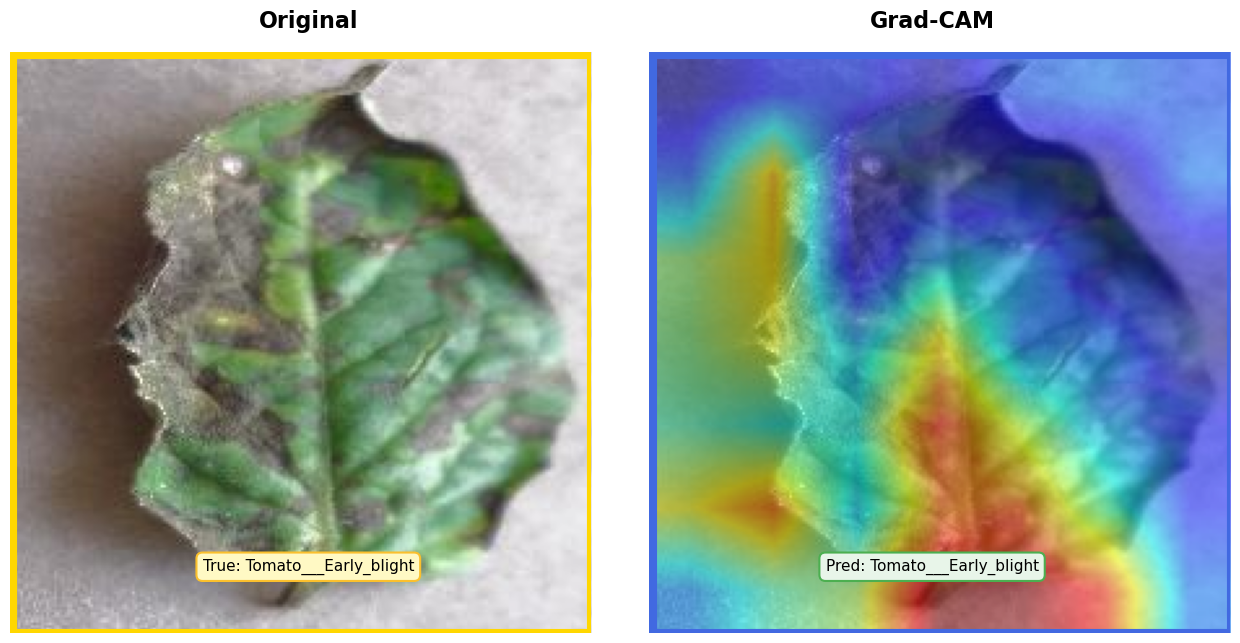

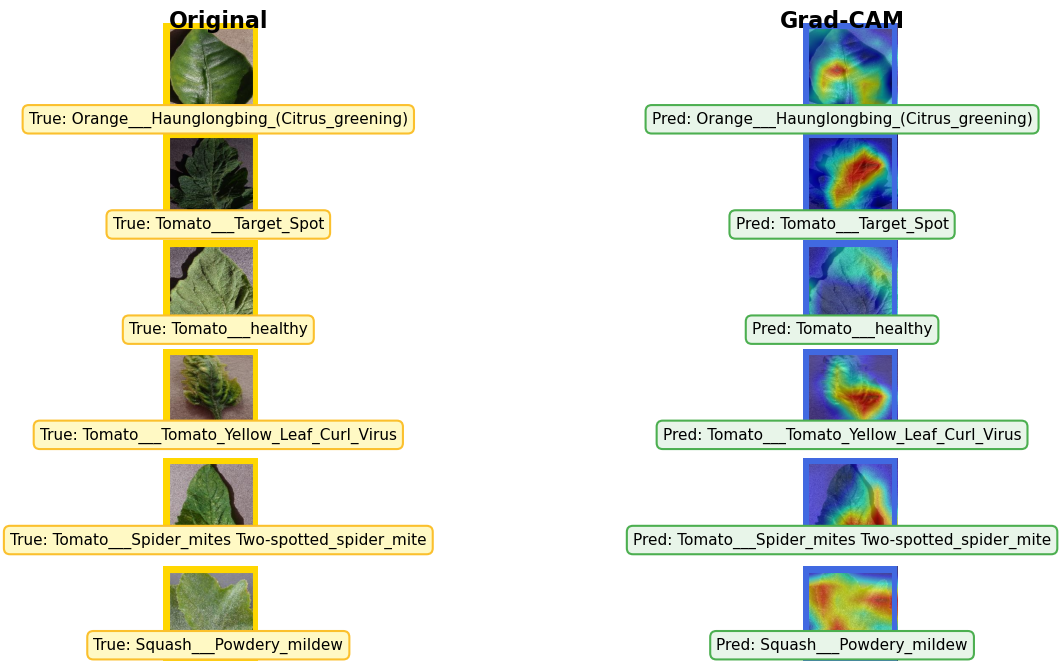

In [11]:
launch_gradcam_gui(
    model=model,
    class_names=class_names,
    device='cuda',
    dataset=test_dataset,
    transform=data_transforms['test']
)

In [ ]:
# --- TFLite Conversion Outline (Requires external tools/environment) ---

# 1. Save the PyTorch model to ONNX format
# dummy_input = torch.randn(1, 3, 224, 224).to(DEVICE)
# torch.onnx.export(trained_model, dummy_input, "resnet50_plantvillage.onnx", verbose=True)

# 2. Convert ONNX to TensorFlow Lite (TFLite)
# This step typically requires an external tool or a Python environment with TensorFlow.
# You would use tools like onnx-tf and TFLite converter in a separate environment.
# Example shell commands (to be run in your terminal, not the notebook):
# pip install onnx-tf
# onnx-tf convert -i resnet50_plantvillage.onnx -o resnet50_tf_model
# tflite_convert --saved_model_dir=resnet50_tf_model --output_file=resnet50_plantvillage.tflite